Steps taken to get an api setup with a neo4j graph database

cd in to the directory that your project will be in 

install pip:
python get-pip.py

install fastapi and uvicorn in one go:
pip install "fastapi[all]"

install neo4j so you can connect to your database form your script:
pip install neo4j

Once you have all of the packages installed, create a graph data base instance.
go to https://neo4j.com/pricing/ and click on the left option that says AuraDB Free. and click sign up: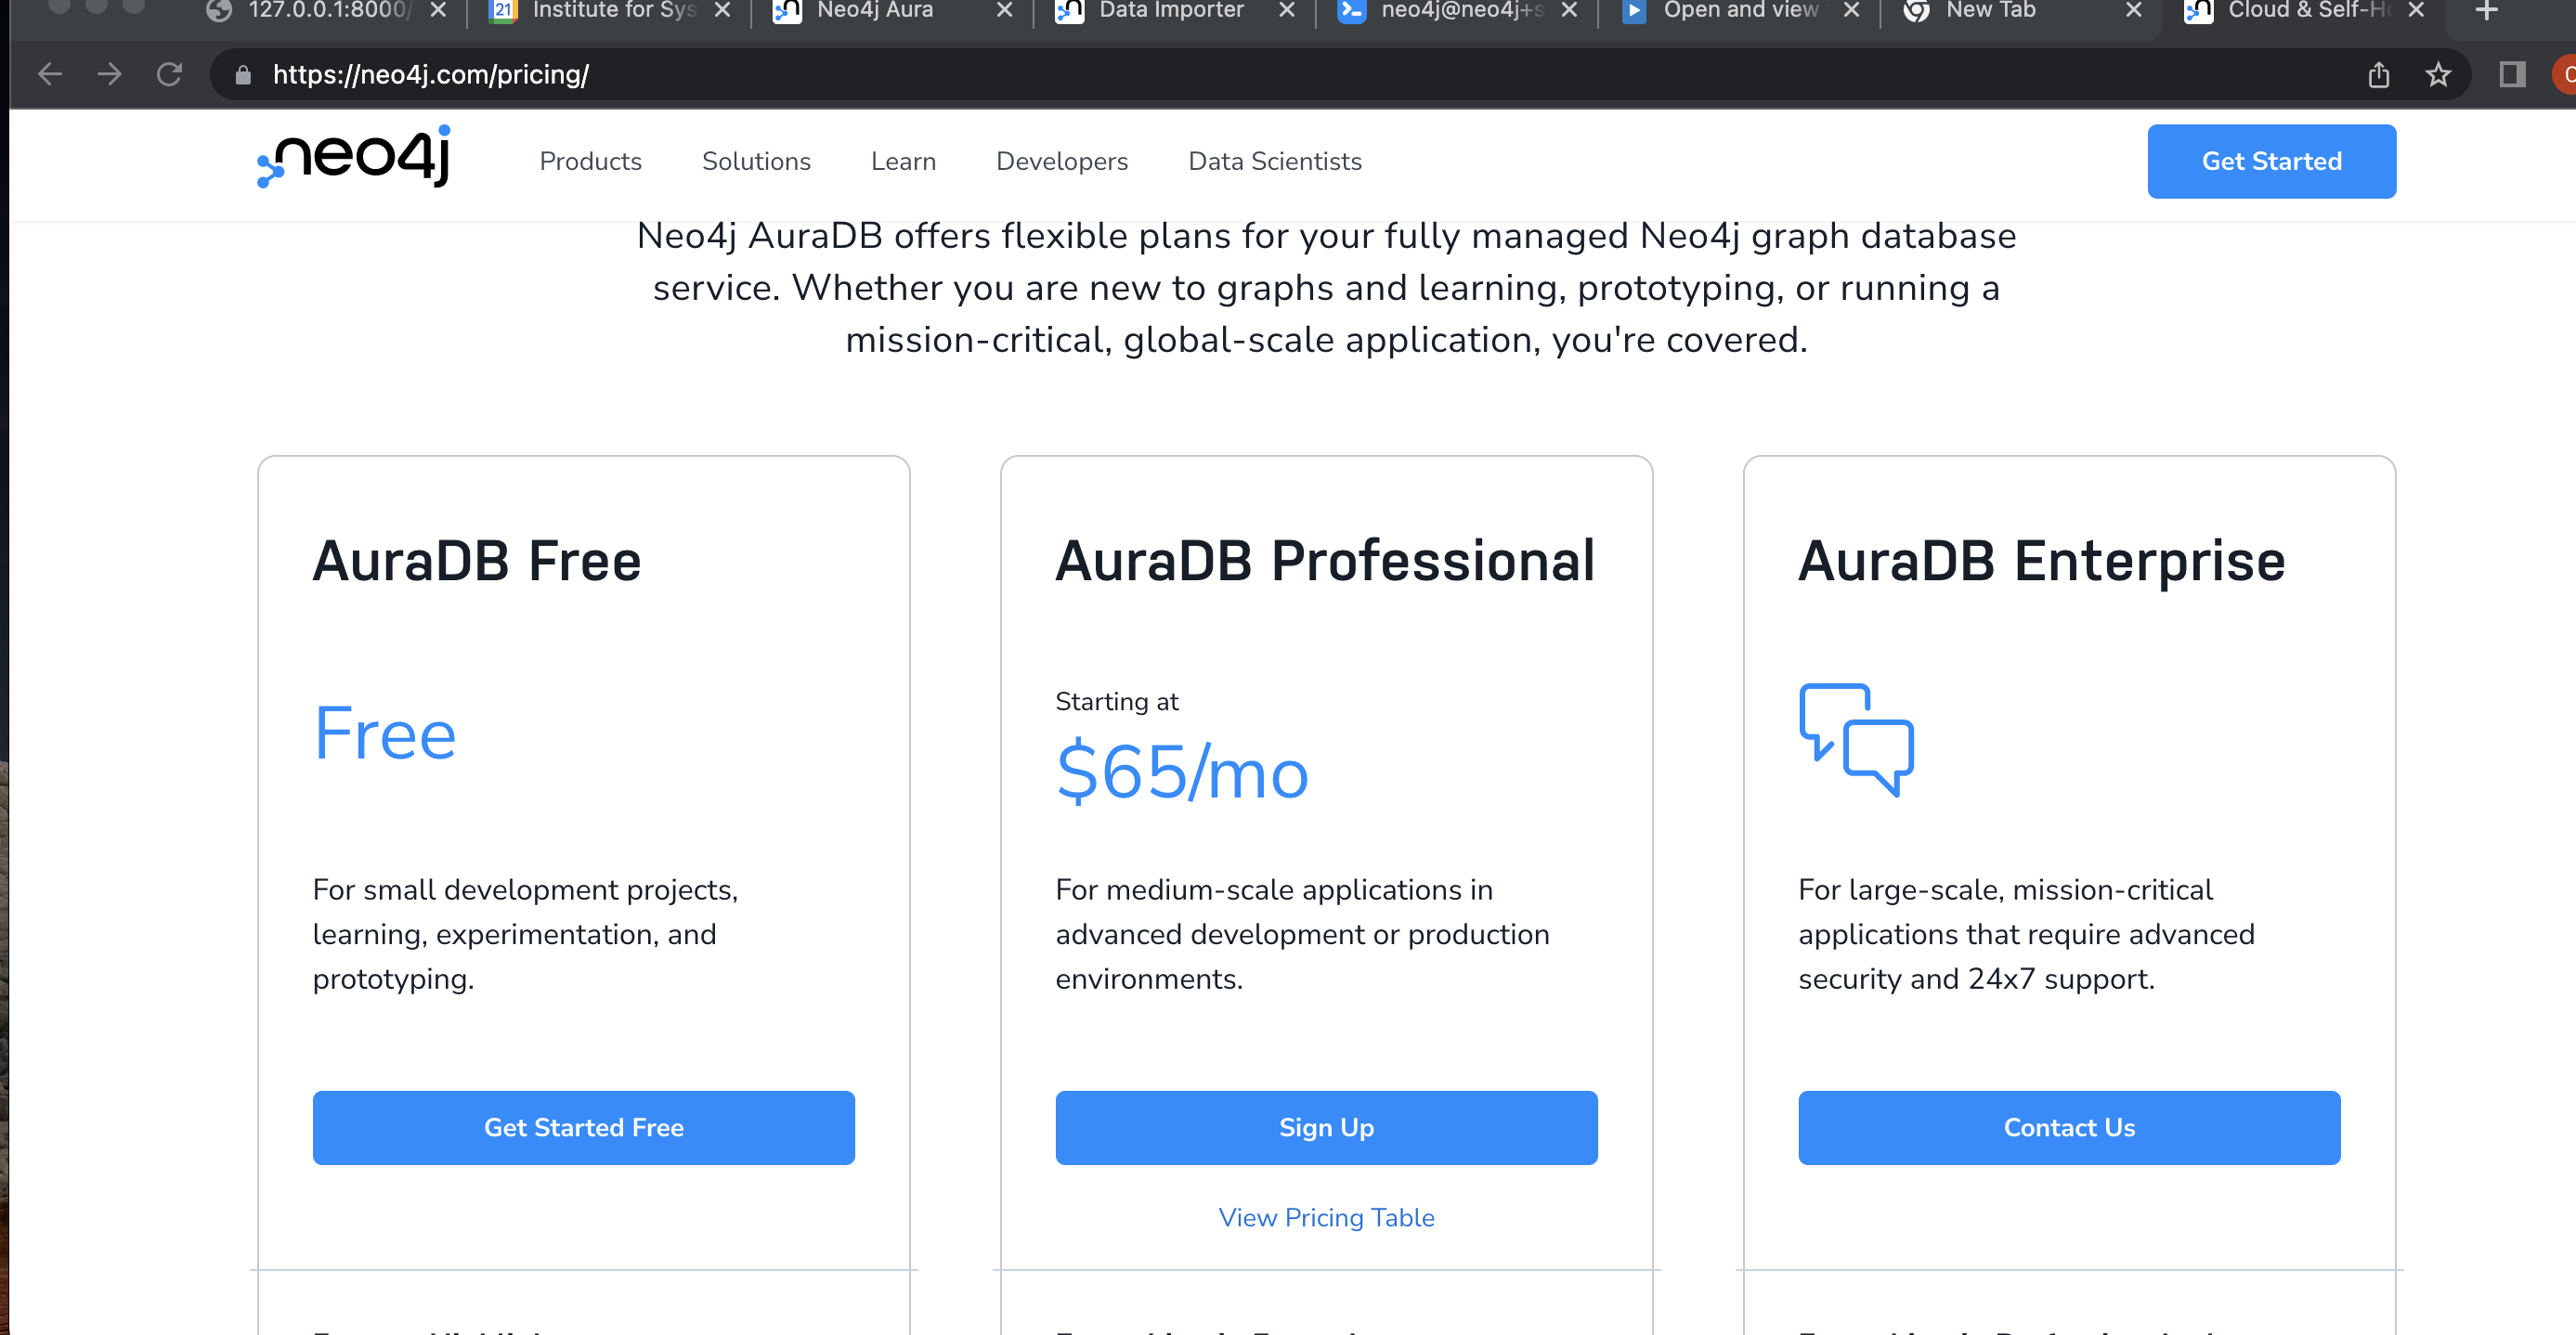


create the account, and save the credentials, this is crucial. then, in the page displaying your instance, click on import: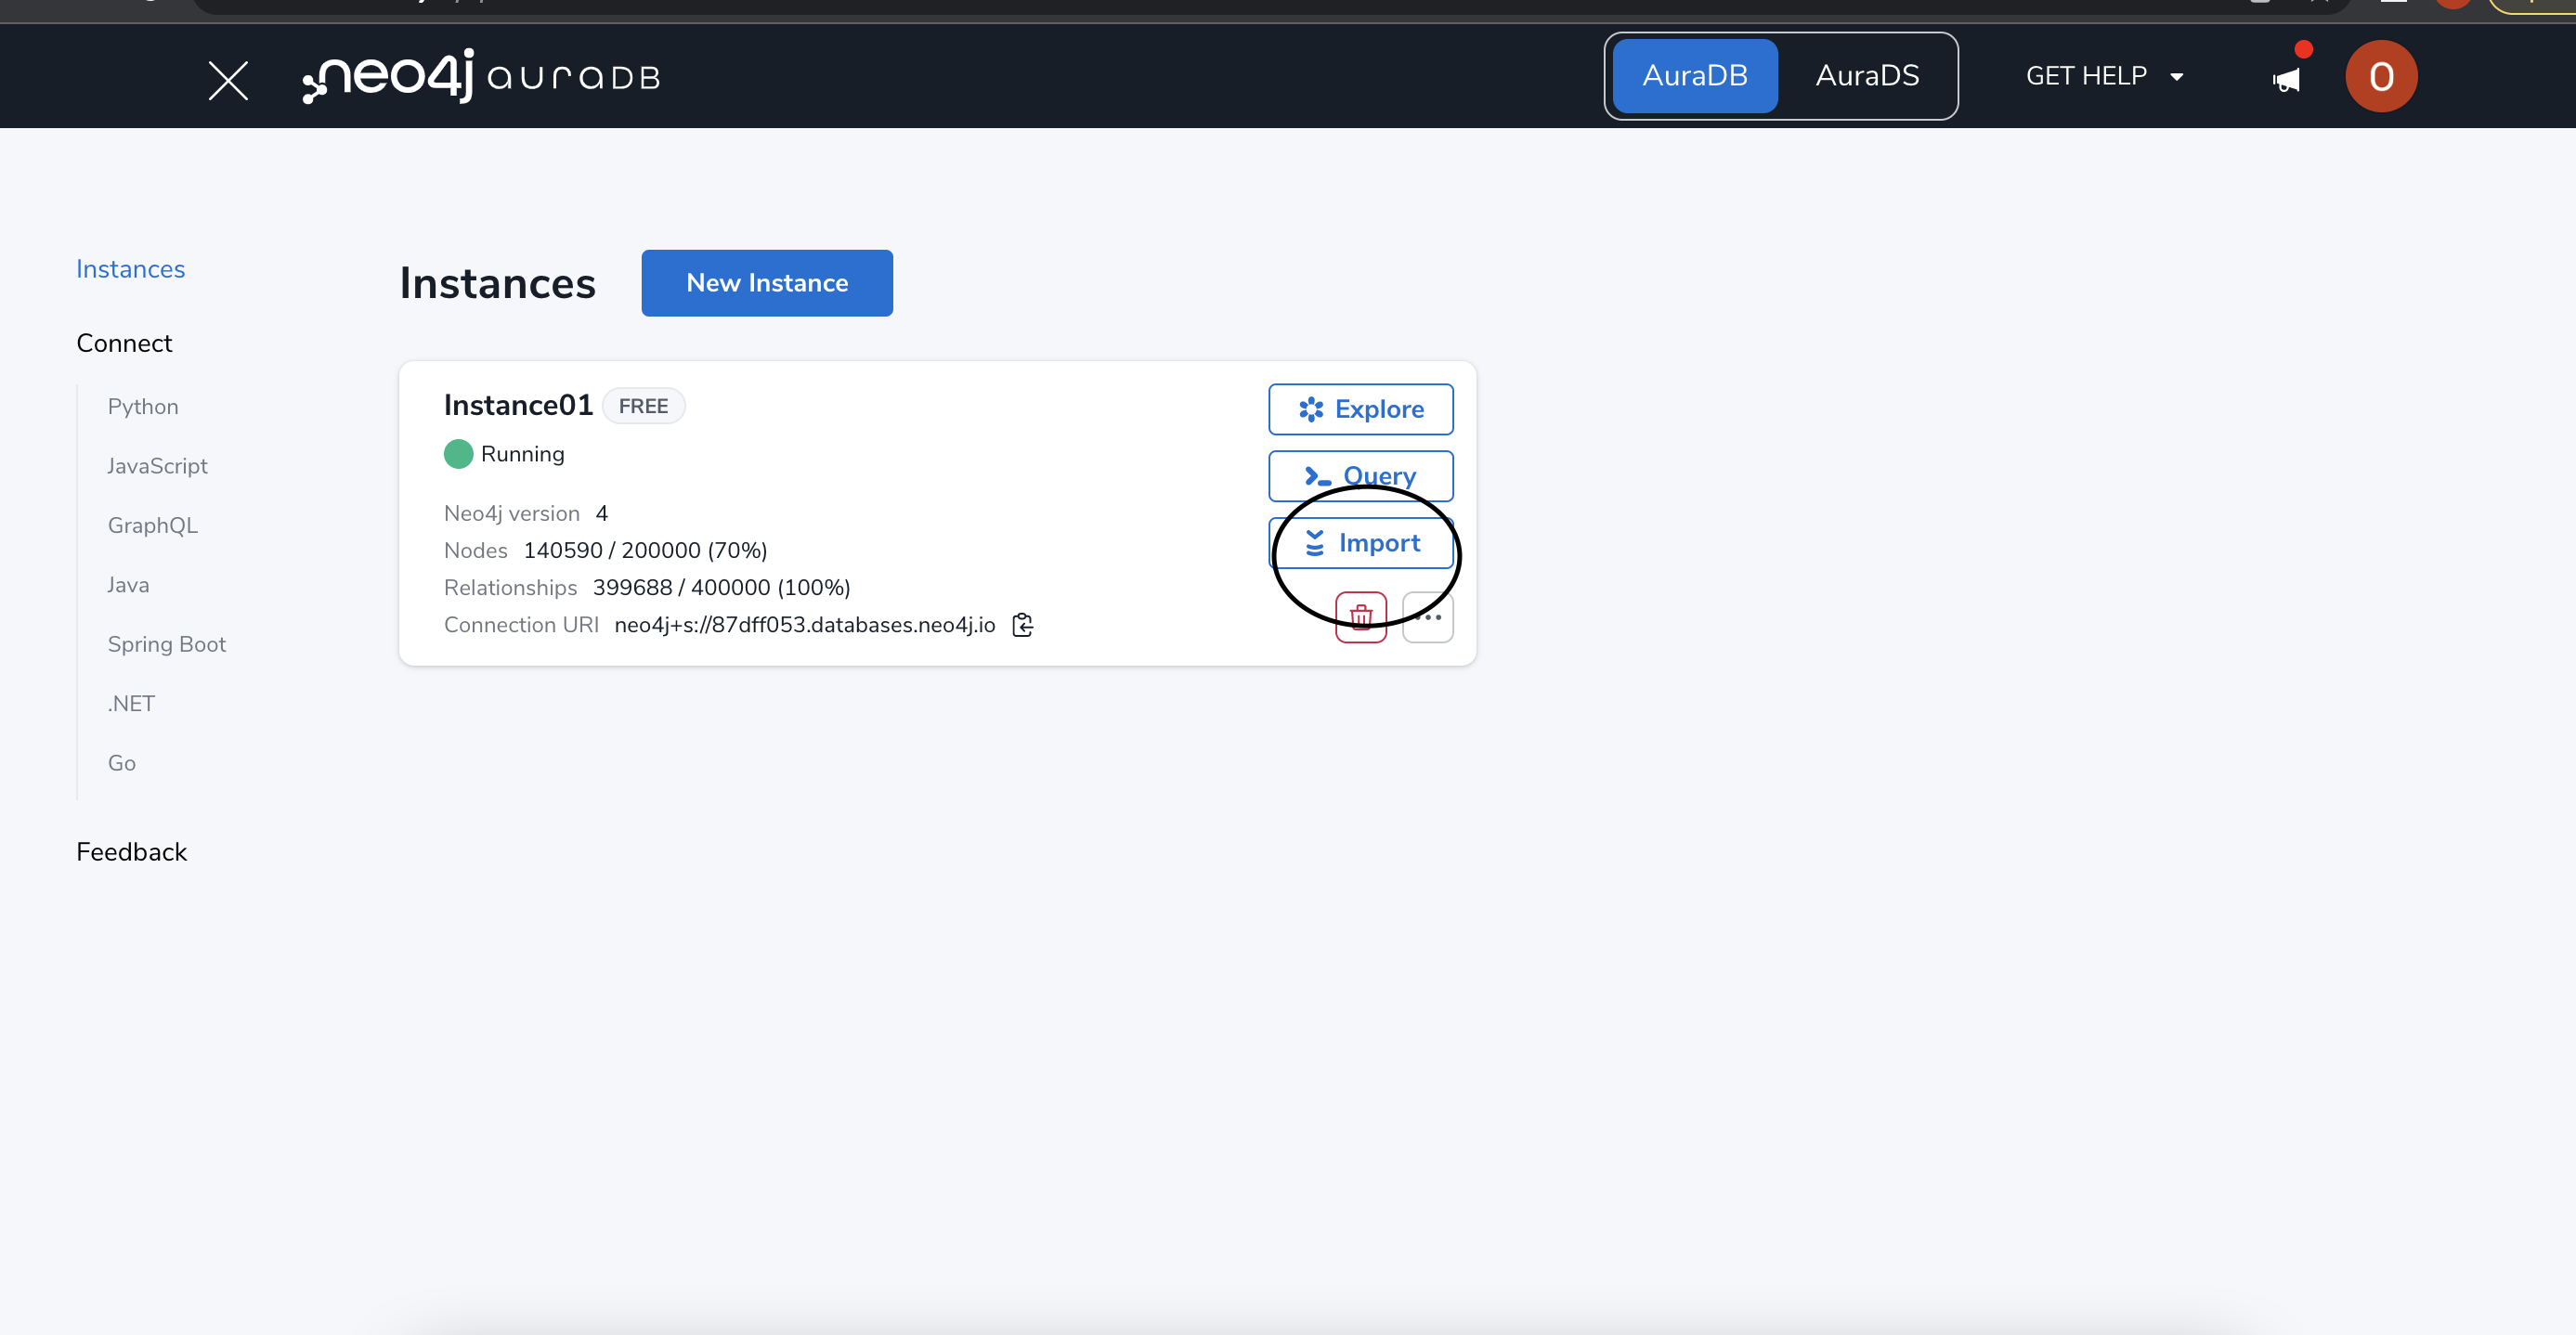

Then go to this github Repo: https://github.com/OmarISB/dbZip

and save the zip file. 




once downloaded, go back to the db instance you have open, and click on the 3 buttons at the top: 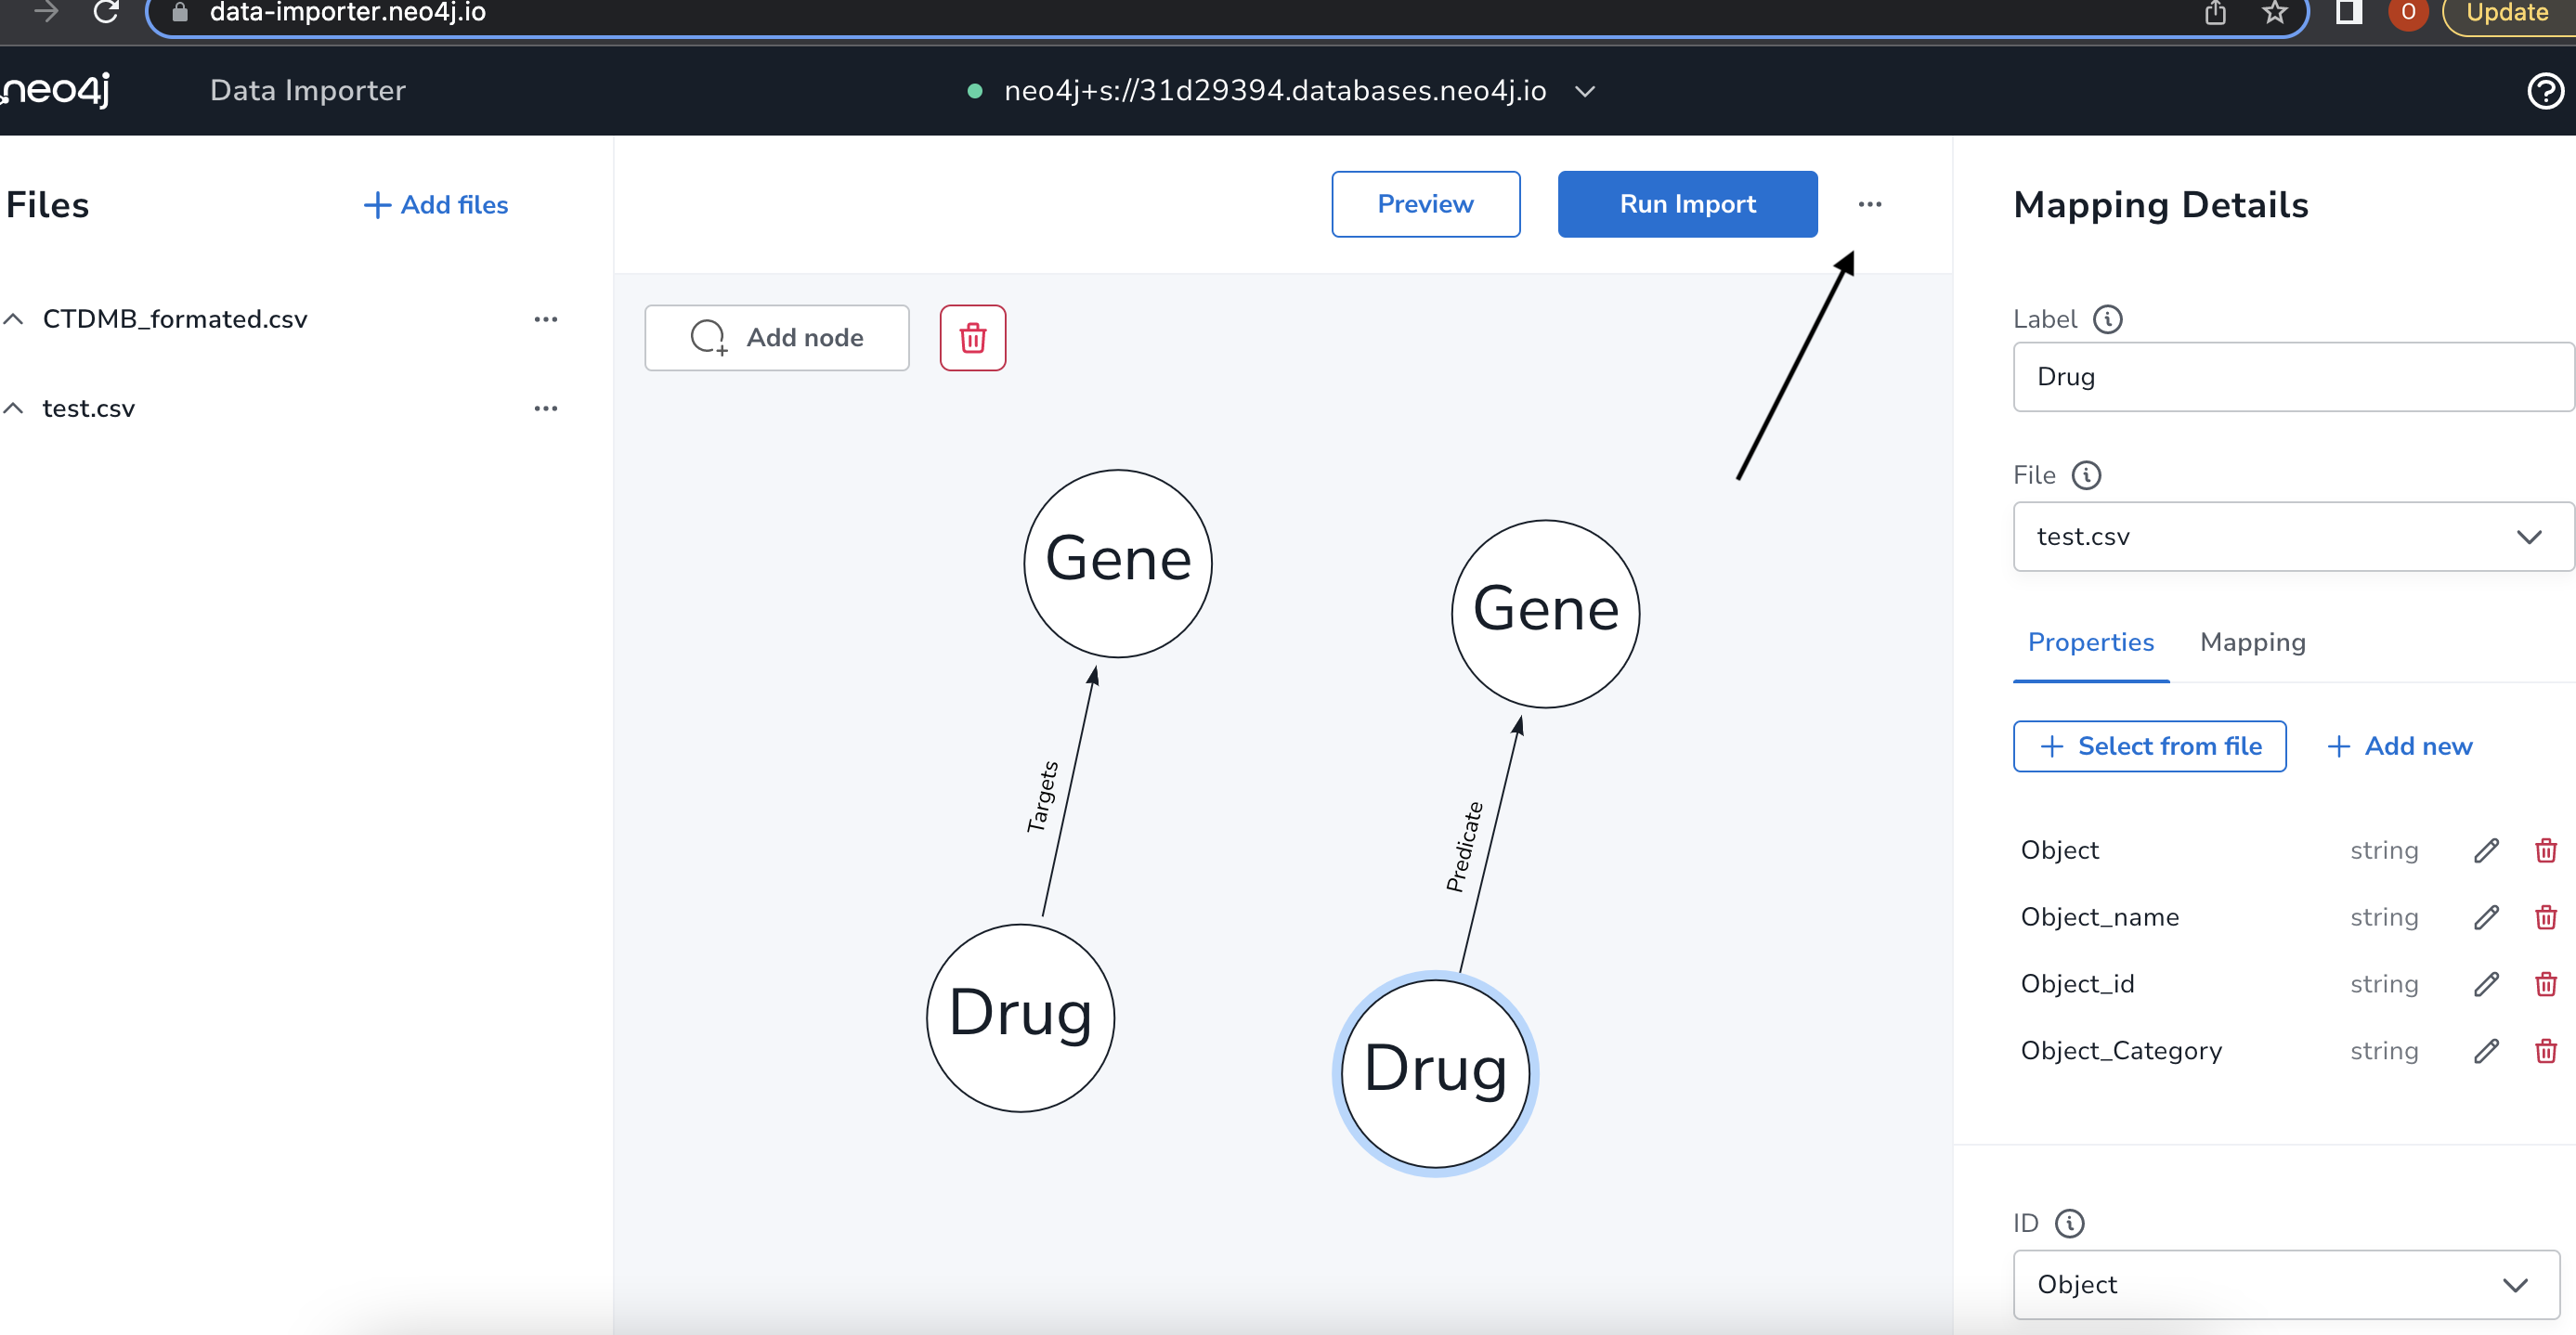

Then click on open model with data: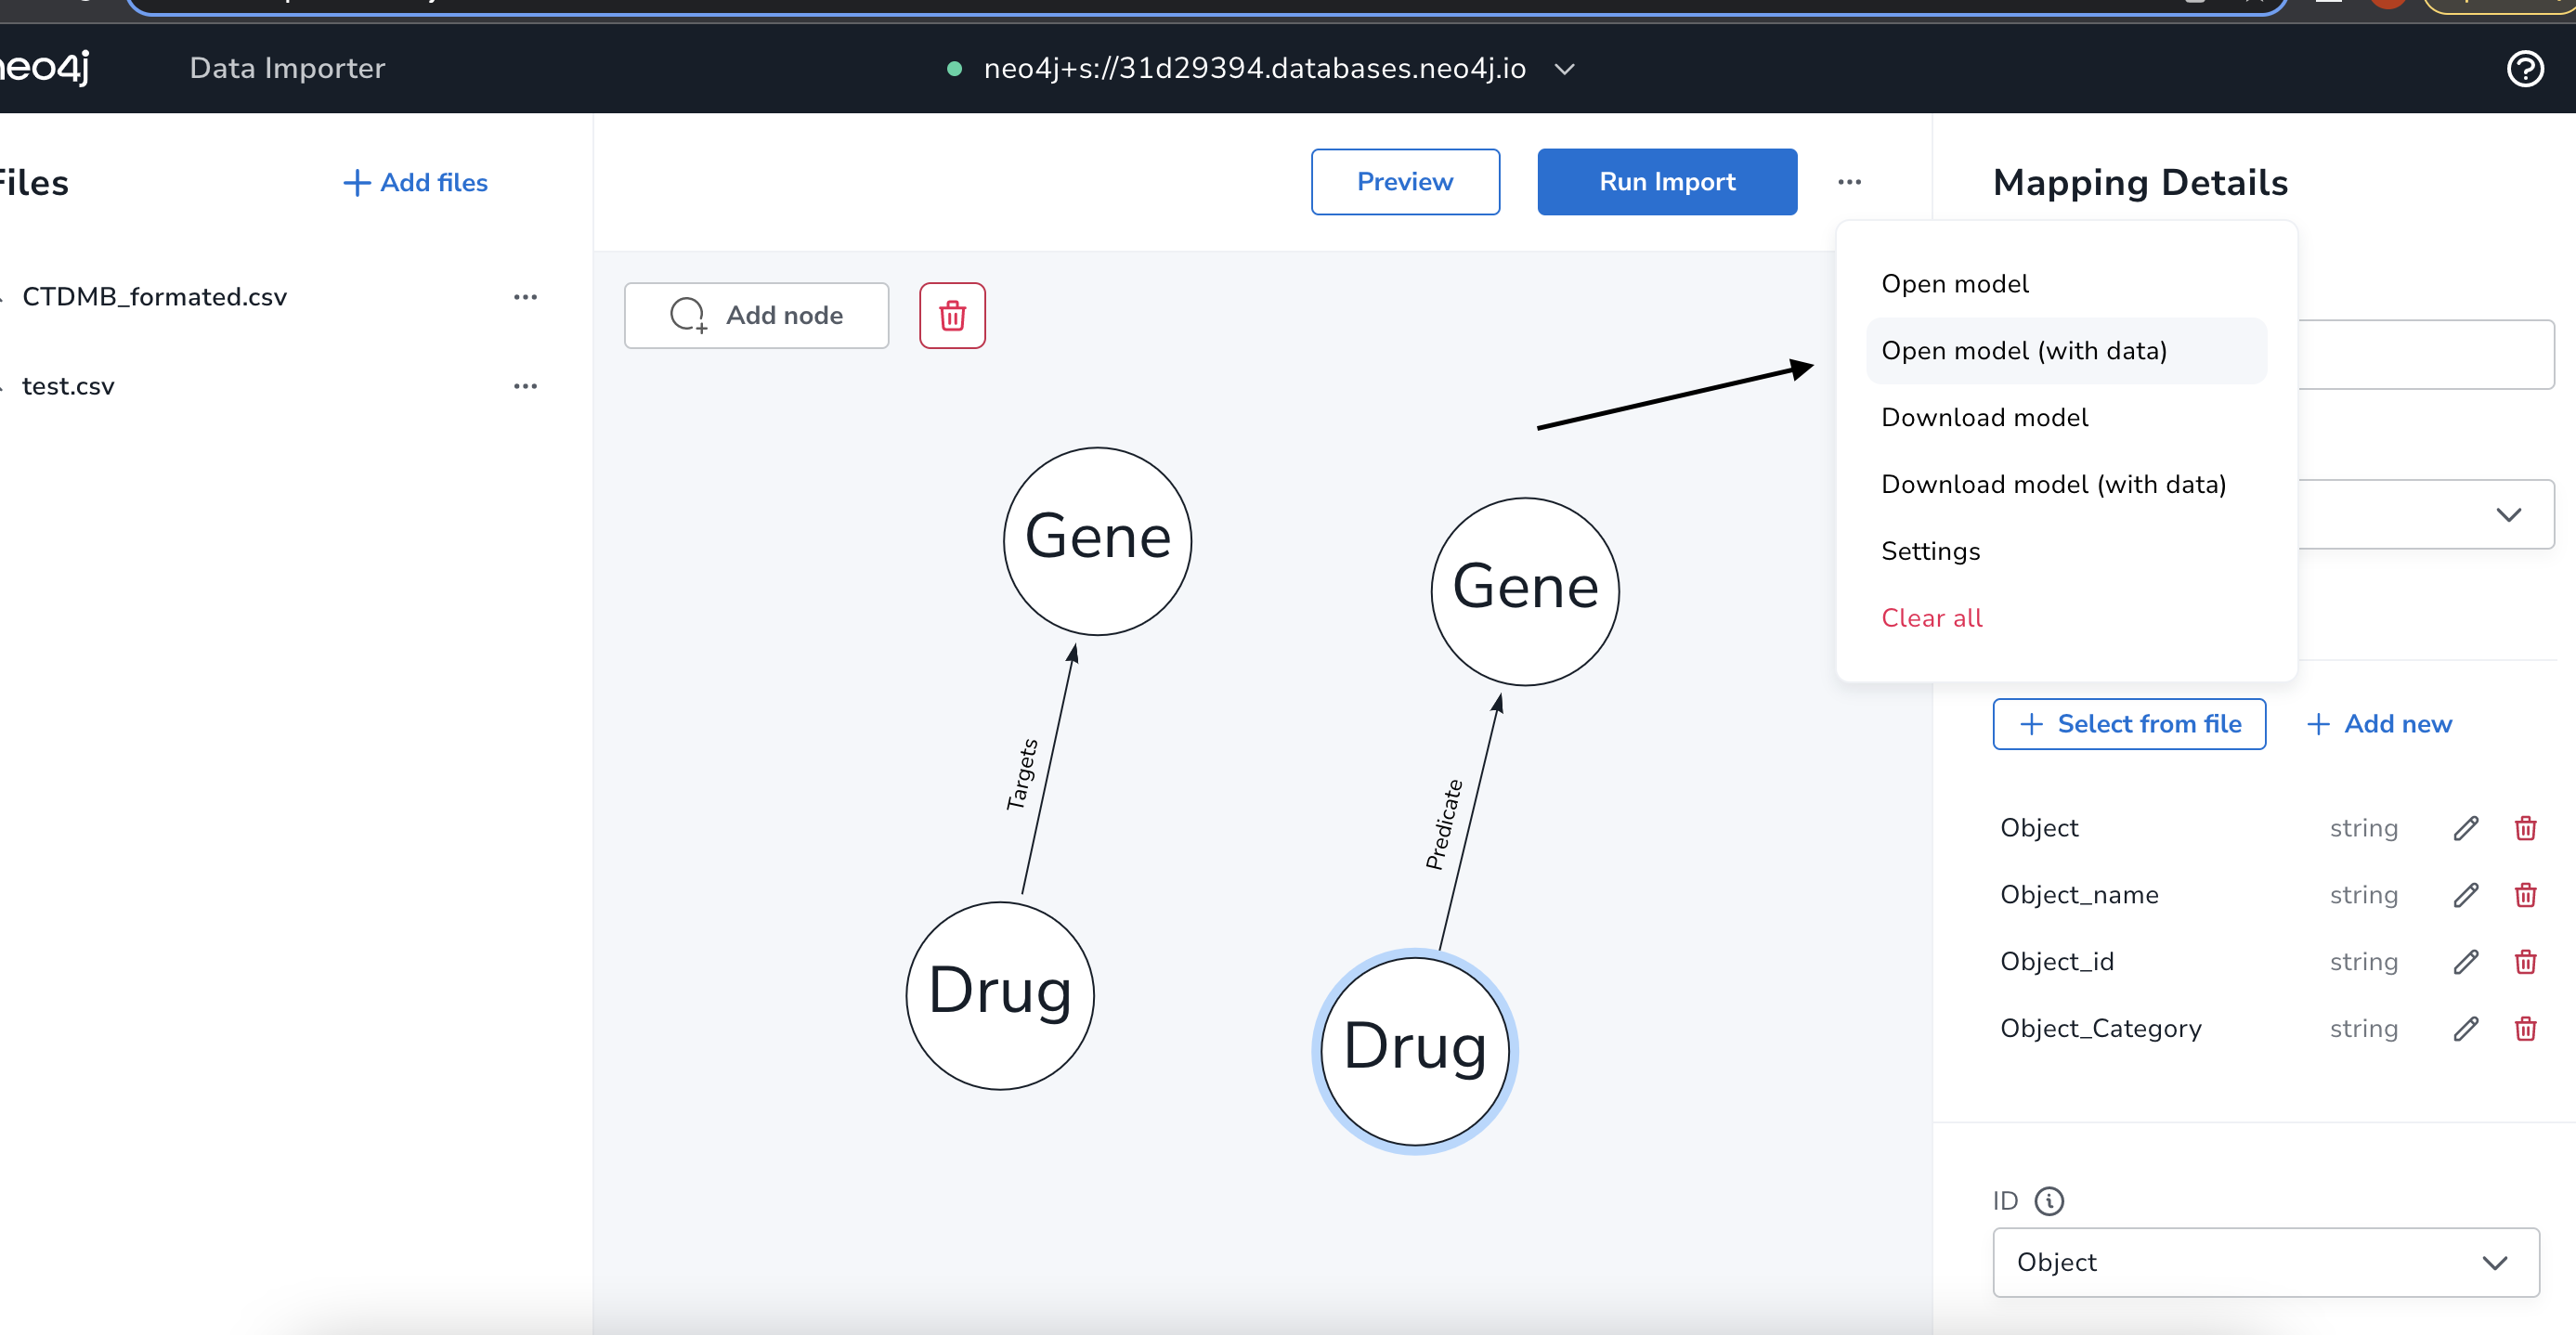

Then from the file explorer click on the json file that was provided in the zip.

After thats completed, click on run import at the top: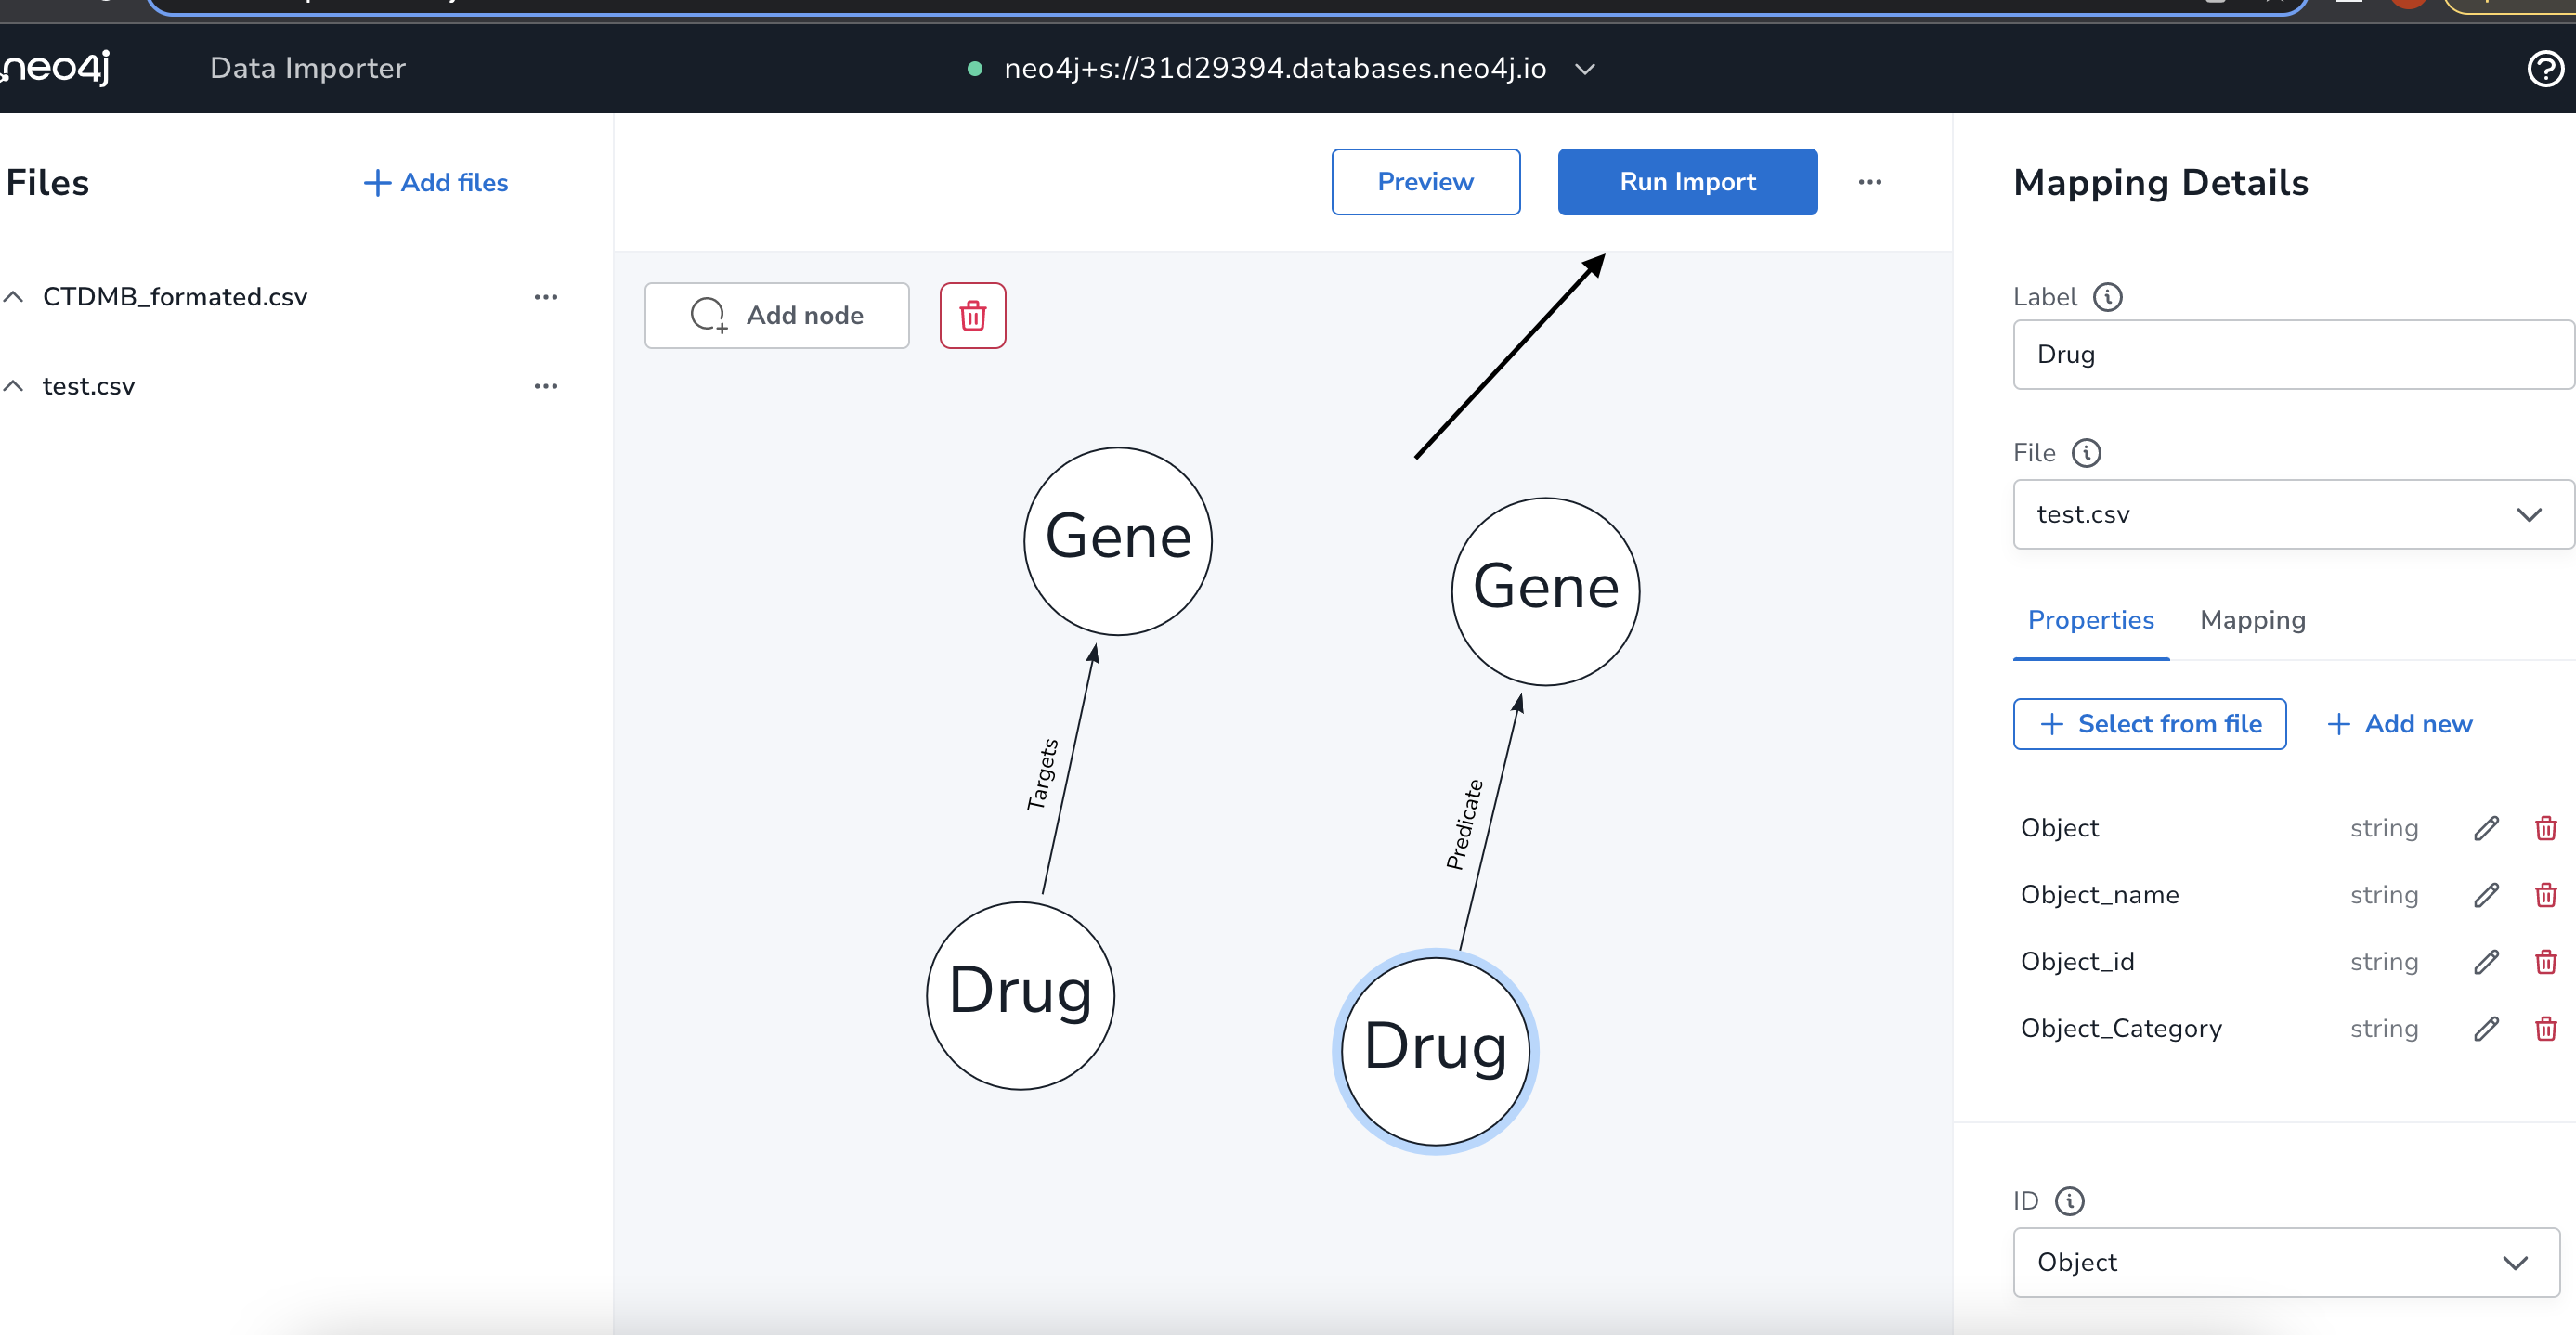

Once complete, copy the code below in to your code editor and insert your credentials. for the instance of the neo4j connecting class called connection

In [ ]:
from neo4j import GraphDatabase
from fastapi import FastAPI
class apiP:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Could not create the driver", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "The driver was not fully initialized"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("The Query did not complete:", e)
        finally: 
            if session is not None:
                session.close()
        return response
    

connection = apiP("your uri","neo4j","your password") 
##put your info right here on top
app=FastAPI()

@app.get('/')
def root():
    return {'root': 'you are in the root of the api'}
@app.get('/GresDrug')
async def read_item(lim: int = 10, drug= str):
        qString= """
        match (d:Drug)-[rel:Predicate]->(g:Gene) 
        where rel.Predicate = 'biolink:associated with resistance to' and d.Object = '{drug}'
        return g limit {lim}
        """.format(lim=lim, drug=drug)
    
        result = connection.query(qString, db='neo4j')
        return {"Genes": result} ## this wont work since the test.csv doesnt contain all of the info
@app.get('/GsensitiveY')
async def count(drug: str, lim: int = 10):
        qString = """
        match (d:Drug)-[rel:Predicate]->(g:Gene) 
        where rel.Predicate = 'biolink:associated with sensitivity to' and d.Object = '{drug}'
        return g limit {lim}
        """.format(drug=drug, lim=lim)
        return {"Genes": connection.query(qString, db='neo4j')}
@app.get('/DrugTGene')
async def count(lim: int = 20, gene= str):
        qString = """
        match (d:Drug)-[rel:Targets]->(g:Gene) where g.Target = '{gene}' return d limit {lim} 
        """.format(lim=lim, gene= gene)
        return {"Drugs": connection.query(qString, db='neo4j')}
@app.get('/GTargetsForDrug')
async def count(lim: int = 10, drug= str):
        qString = """
        match (d:Drug)-[rel:Targets]->(g:Gene) where d.Drug = '{drug}' return g limit {lim} 
        """.format(lim=lim, drug = drug)
        return {"Genes": connection.query(qString, db='neo4j')}
@app.get('/GwithSaR')
async def count(lim: int = 10, drug = str):
        qString = """
        match (d:Drug)-[rel:Targets]->(g:Gene) where d.Drug = '{drug}' 
        with d.Drug as drug, g.Target as gene  
        match (d:Drug)-[rel:Predicate]->(g:Gene) 
        where rel.Predicate = 'biolink:associated with sensitivity to' and d.Object = drug and g.Subject = gene  
        return g limit {lim}
        """.format(lim=lim, drug = drug)
        return {"Genes": connection.query(qString, db='neo4j')} 
@app.get('/Genes')
async def genes(lim:int = 20):
    qString = "match (g:Gene) return g limit  {lim}".format(lim=lim)
    return {"Genes": connection.query(qString, db='neo4j')}
@app.get('/Drugs')
async def genes(lim:int = 20):
    qString = "match (d:Drug) return d limit  {lim}".format(lim=lim)
    return {"Drugs": connection.query(qString, db='neo4j')}

then in the command line, run: python3 -m uvicorn main:app --reload

then using the url they give you go to it and test out the endpoints that are coded in to the python script!

NOTE: the first first query endpoint in the script may not work since we are using the test csv that doesnt contain all the data so the proccess would be quicker. 